In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.utils import plot_model
from scipy.stats import scoreatpercentile
import warnings
import random
import os

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [6]:
from google.colab import files


uploaded = files.upload()


Saving sopan_data.csv to sopan_data (1).csv


In [7]:
df=pd.read_csv('sopan_data.csv')

In [8]:
df.shape

(30816, 12)

In [9]:
df.head()

,Date,Month,Day,Hour,Minute,PV_Demand,temp,wind_speed,rain_1h,snow_1h,clouds_all,precip_1h
0,10/9/2021,10,9,0,0,0.7,293.12,2.57,0.0,0.0,100,0.0
1,10/9/2021,10,9,0,15,0.7,293.12,2.57,0.0,0.0,100,0.0
2,10/9/2021,10,9,0,30,0.7,293.12,2.57,0.0,0.0,100,0.0
3,10/9/2021,10,9,0,45,0.7,293.12,2.57,0.0,0.0,100,0.0
4,10/9/2021,10,9,1,0,0.7,292.57,2.06,0.0,0.0,40,0.0


In [10]:
df.describe()

,Month,Day,Hour,Minute,PV_Demand,temp,wind_speed,rain_1h,snow_1h,clouds_all,precip_1h
count,30816.000000,30816.000000,30816.000000,30816.000000,30816.000000,30816.000000,30816.000000,30816.000000,30816.000000,30816.000000,30815.000000
mean,6.180750,15.781931,11.500000,22.500000,14.170334,286.655402,3.812989,0.141564,0.006281,34.443146,0.147850
std,3.533448,8.636933,6.922299,16.770782,23.870428,10.875958,2.551229,0.906535,0.090340,43.961739,0.910063
min,1.000000,1.000000,0.000000,0.000000,0.000000,259.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,9.000000,5.750000,11.250000,0.000000,278.160000,2.060000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,16.000000,11.500000,22.500000,0.700000,286.820000,3.600000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,23.000000,17.250000,33.750000,18.252500,295.512500,5.140000,0.000000,0.000000,100.000000,0.000000
max,12.000000,31.000000,23.000000,45.000000,97.660000,310.780000,14.920000,51.820000,3.300000,100.000000,51.820000


In [11]:
df.drop(['snow_1h'], axis=1, inplace=True)

In [12]:
df.isnull().sum()

Date          0
Month         0
Day           0
Hour          0
Minute        0
PV_Demand     0
temp          0
wind_speed    0
rain_1h       0
clouds_all    0
precip_1h     1
dtype: int64

In [13]:
df['precip_1h']=df['precip_1h'].fillna(0)

In [14]:
# Membuat kolom baru "Year"
df['Year']  = df['Date'].str[-4:]
df['Month'] = df['Date'].apply(lambda x: x.split('/')[0])
# Menggabungkan Year, Month, Day, Hour, Minute menjadi kolom Period
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], format='%Y-%m-%d')
# Konversi kolom 'Year', 'Month', 'Day', 'Hour', 'Minute' menjadi kolom period
df['Period'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

In [15]:
df=df.sort_values(by=['Period'])

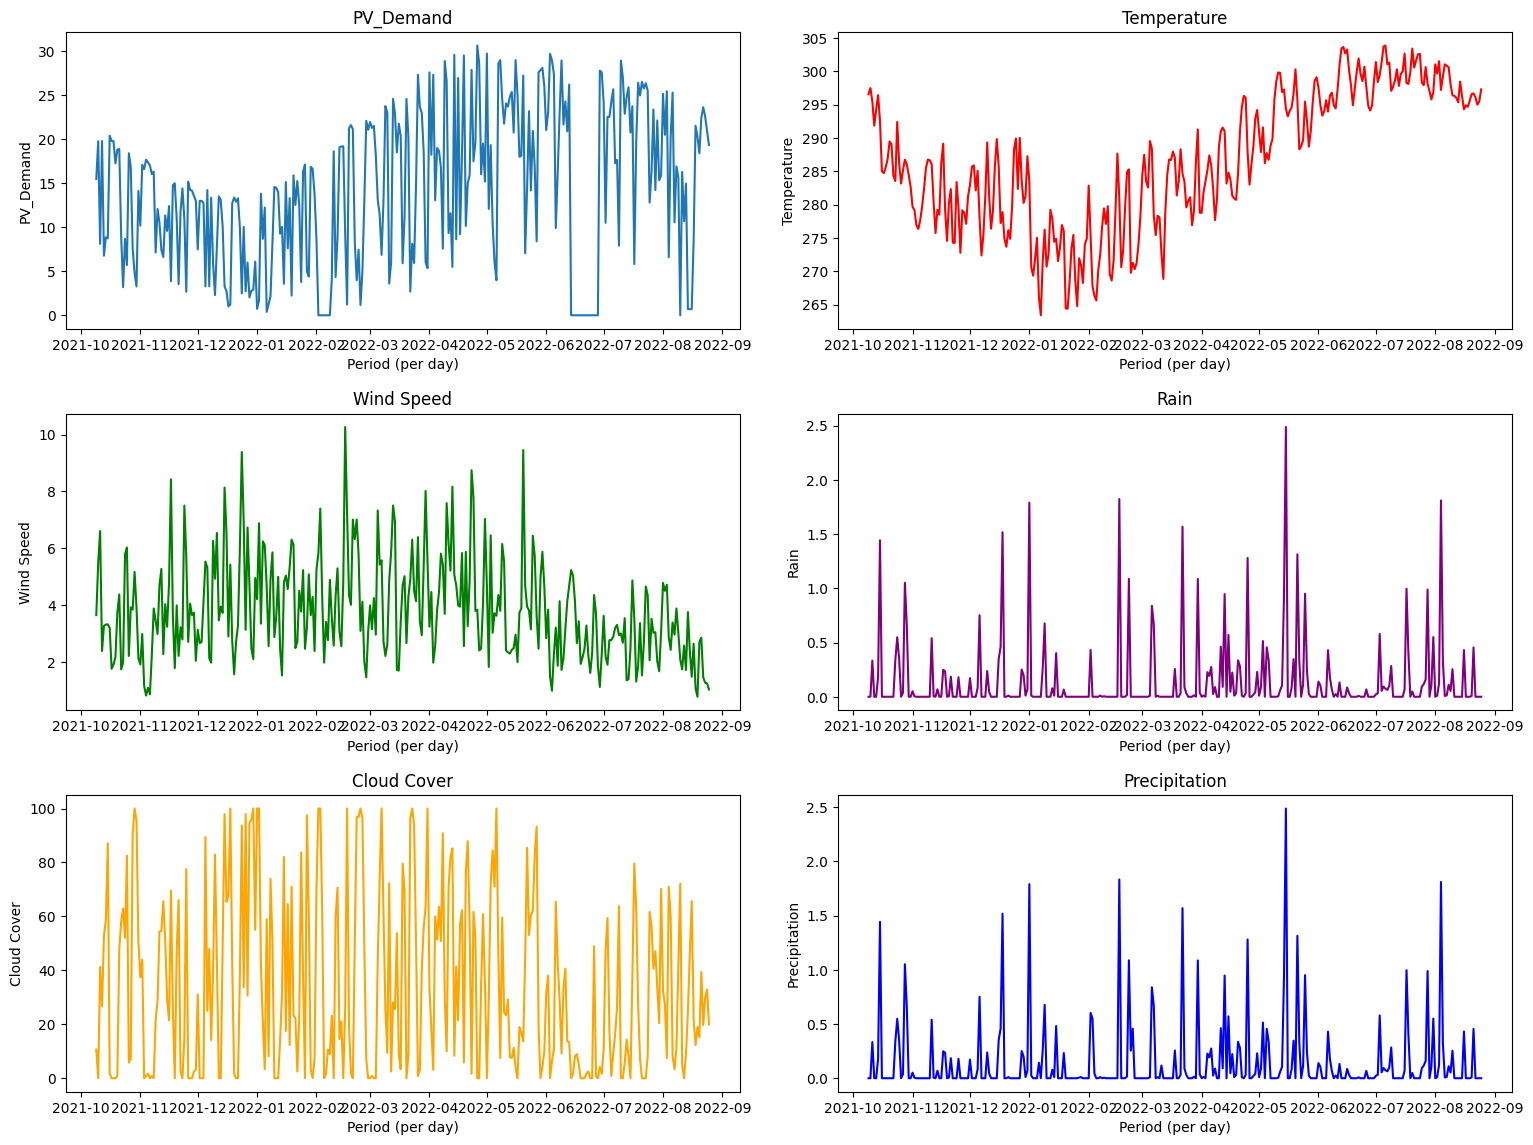

In [16]:
# Melakukan group by pada kolom Period dan menerapkan fungsi mean()
grouped_data = df[['Date','PV_Demand', 'temp', 'wind_speed', 'rain_1h', 'clouds_all', 'precip_1h']].groupby(['Date']).mean()
grouped_data=grouped_data.sort_values(by=['Date'])
# Membuat subplot dengan 3 baris dan 2 kolom
fig, axs = plt.subplots(3, 2, figsize=(16, 12))
fig.tight_layout(pad=4.0)

# Plot untuk kolom 'PV_Demand'
axs[0, 0].plot(grouped_data.index, grouped_data['PV_Demand'])
axs[0, 0].set_title('PV_Demand')
axs[0, 0].set_xlabel('Period (per day)')
axs[0, 0].set_ylabel('PV_Demand')

# Plot untuk kolom 'temp'
axs[0, 1].plot(grouped_data.index, grouped_data['temp'], color='red')
axs[0, 1].set_title('Temperature')
axs[0, 1].set_xlabel('Period (per day)')
axs[0, 1].set_ylabel('Temperature')

# Plot untuk kolom 'wind_speed'
axs[1, 0].plot(grouped_data.index, grouped_data['wind_speed'], color='green')
axs[1, 0].set_title('Wind Speed')
axs[1, 0].set_xlabel('Period (per day)')
axs[1, 0].set_ylabel('Wind Speed')

# Plot untuk kolom 'rain_1h'
axs[1, 1].plot(grouped_data.index, grouped_data['rain_1h'], color='purple')
axs[1, 1].set_title('Rain')
axs[1, 1].set_xlabel('Period (per day)')
axs[1, 1].set_ylabel('Rain')

# Plot untuk kolom 'clouds_all'
axs[2, 0].plot(grouped_data.index, grouped_data['clouds_all'], color='orange')
axs[2, 0].set_title('Cloud Cover')
axs[2, 0].set_xlabel('Period (per day)')
axs[2, 0].set_ylabel('Cloud Cover')

# Plot untuk kolom 'precip_1h'
axs[2, 1].plot(grouped_data.index, grouped_data['precip_1h'], color='blue')
axs[2, 1].set_title('Precipitation')
axs[2, 1].set_xlabel('Period (per day)')
axs[2, 1].set_ylabel('Precipitation')

# Menampilkan plot
plt.show()

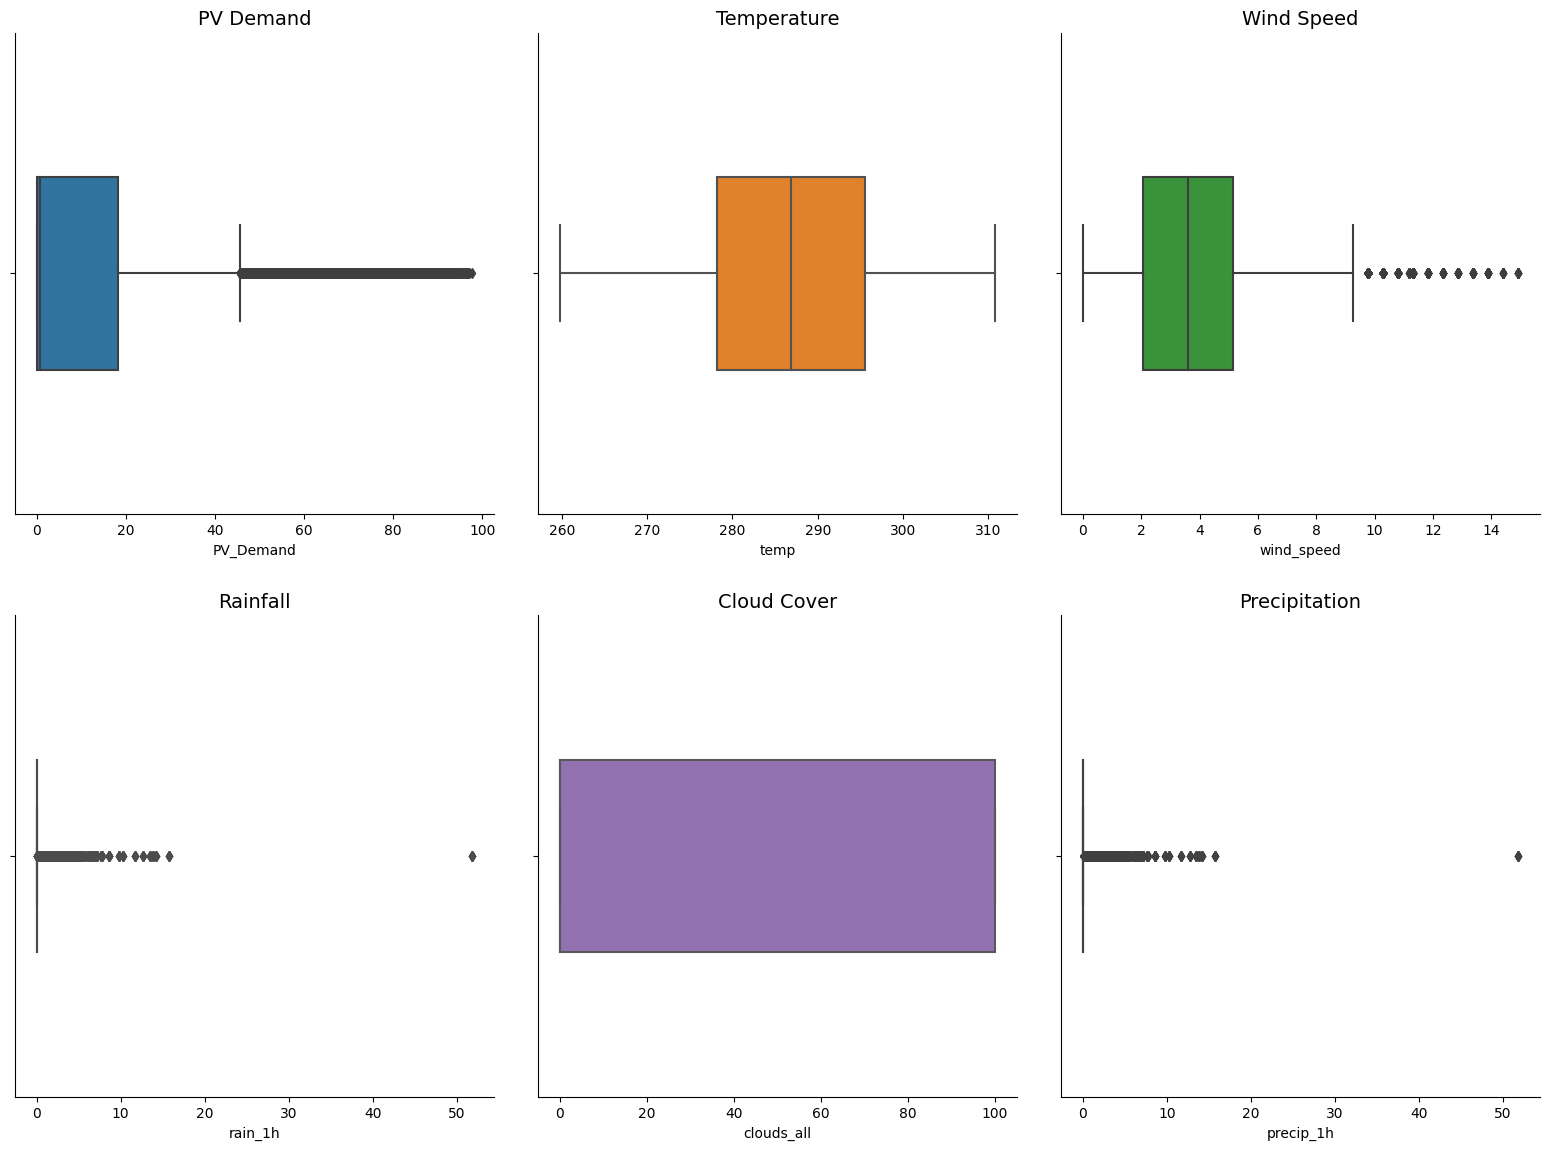

In [17]:
# Mendefinisikan subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))

# Membuat boxplot untuk masing-masing kolom dengan seaborn
sns.boxplot(x='PV_Demand', data=df, ax=axes[0, 0], color='#1f77b4', width=0.4)
sns.boxplot(x='temp', data=df, ax=axes[0, 1], color='#ff7f0e', width=0.4)
sns.boxplot(x='wind_speed', data=df, ax=axes[0, 2], color='#2ca02c', width=0.4)
sns.boxplot(x='rain_1h', data=df, ax=axes[1, 0], color='#d62728', width=0.4)
sns.boxplot(x='clouds_all', data=df, ax=axes[1, 1], color='#9467bd', width=0.4)
sns.boxplot(x='precip_1h', data=df, ax=axes[1, 2], color='#8c564b', width=0.4)

# Memberi judul pada setiap subplot
axes[0, 0].set_title('PV Demand', fontsize=14)
axes[0, 1].set_title('Temperature', fontsize=14)
axes[0, 2].set_title('Wind Speed', fontsize=14)
axes[1, 0].set_title('Rainfall', fontsize=14)
axes[1, 1].set_title('Cloud Cover', fontsize=14)
axes[1, 2].set_title('Precipitation', fontsize=14)

# Menghilangkan spines yang tidak diperlukan
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Mengatur tata letak subplot dan memberi ruang antara subplot
plt.tight_layout(pad=2.5)

# Menampilkan plot
plt.show()

**matriks korelasi**

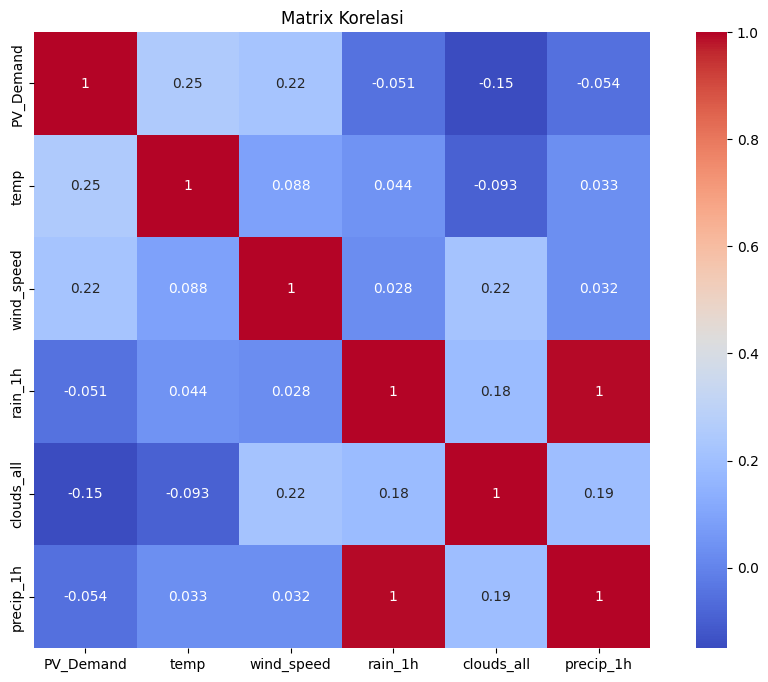

In [18]:
# Mengambil kolom yang relevan
columns = ['PV_Demand', 'temp', 'wind_speed', 'rain_1h', 'clouds_all', 'precip_1h']
df_corr = df[columns]
# Membuat matriks korelasi
corr_matrix = df_corr.corr()
# Membuat heatmap matriks korelasi
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
# Memberi judul pada plot
plt.title('Matrix Korelasi')
# Menampilkan plot
plt.show()

In [19]:
features = ['Month', 'Day', 'Hour', 'Minute', 'temp', 'wind_speed', 'clouds_all', 'precip_1h']
target = 'PV_Demand'

X = df[features]
y = df[target]

y=np.log10(y+1)

**Membagi Data menjadi train, validation, dan test set**


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_valid, X_test, y_valid, y_test= train_test_split(X_test, y_test, test_size=0.1, shuffle=False)

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


In [22]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 1
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, time_steps)
X_valid_seq, y_valid_seq = create_sequences(X_valid_scaled, y_valid.values, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, time_steps)

# **model 1**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18,753
Trainable params: 18,753
Non-trainable params: 0
_________________________________________________________________
None


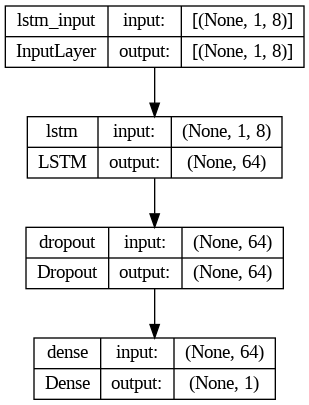

In [23]:
model = Sequential()
model.add(LSTM(64, input_shape=(time_steps, X_train_seq.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))
print(model.summary())
plot_model(model, show_shapes=True)

In [24]:
# Definisikan optimizer Adam dengan learning rate yang diinginkan
optimizer = Adam(learning_rate=0.0001)  
model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=RootMeanSquaredError())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss',min_delta=0.01, patience = 12, verbose = 1)
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=2)
mcp = tf.keras.callbacks.ModelCheckpoint(filepath = 'lstm_model_weights.h5', monitor = 'val_root_mean_squared_error', 
                      save_best_only = True, verbose = 1)

In [25]:
history = model.fit(
        X_train_seq,
        y_train_seq,
        epochs=20,
        batch_size=32,
        validation_data=(X_valid_seq, y_valid_seq),
        callbacks=[early_stopping, reduce_lr, mcp]
    )

Epoch 1/20
762/771 [============================>.] - ETA: 0s - loss: 0.6584 - root_mean_squared_error: 0.8114
Epoch 1: val_root_mean_squared_error improved from inf to 0.72606, saving model to lstm_model_weights.h5
771/771 [==============================] - 8s 6ms/step - loss: 0.6561 - root_mean_squared_error: 0.8100 - val_loss: 0.5272 - val_root_mean_squared_error: 0.7261 - lr: 1.0000e-04
Epoch 2/20
759/771 [============================>.] - ETA: 0s - loss: 0.4658 - root_mean_squared_error: 0.6825
Epoch 2: val_root_mean_squared_error improved from 0.72606 to 0.66088, saving model to lstm_model_weights.h5
771/771 [==============================] - 4s 5ms/step - loss: 0.4649 - root_mean_squared_error: 0.6818 - val_loss: 0.4368 - val_root_mean_squared_error: 0.6609 - lr: 1.0000e-04
Epoch 3/20
768/771 [============================>.] - ETA: 0s - loss: 0.4223 - root_mean_squared_error: 0.6499
Epoch 3: val_root_mean_squared_error improved from 0.66088 to 0.64405, saving model to lstm_model

nilai MAE, MSE, dan RMSE yang telah dihitung adalah hasil evaluasi performa model LSTM dalam memprediksi PV_demand

In [26]:
y_pred = model.predict(X_test_seq)

mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

20/20 [==============================] - 1s 3ms/step
MAE: 0.41543060646056534
MSE: 0.24052114130279514
RMSE: 0.4904295477464578


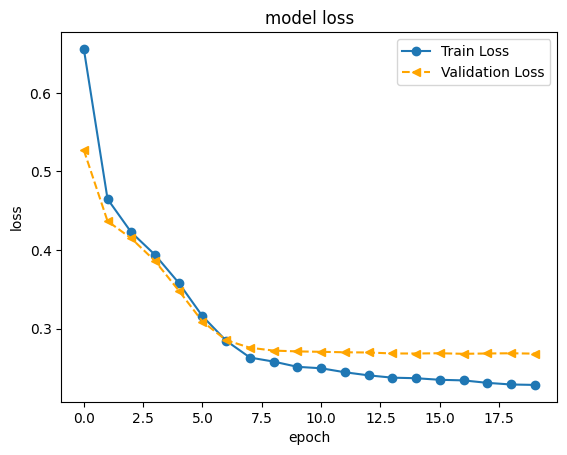

In [27]:
# summarize history for loss
plt.plot(history.history['loss'], '-o', label='Train Loss')
plt.plot(history.history['val_loss'],'--<', color='orange',  label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

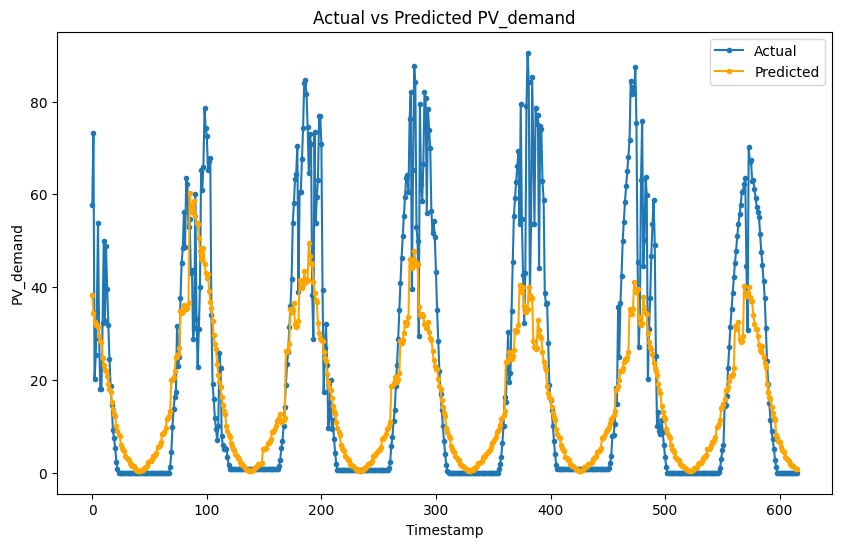

In [28]:
# Membuat array indeks untuk data
index = aa=[x for x in range(len(y_pred))]

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(index, np.power(10, y_test_seq) - 1, label='Actual', marker='.')
plt.plot(index, np.power(10, y_pred+0.5) - 1, label='Predicted', marker='.', color='orange')

# Menambahkan label dan judul plot
plt.xlabel('Timestamp')
plt.ylabel('PV_demand')
plt.title('Actual vs Predicted PV_demand')

# Menambahkan legenda
plt.legend()

# Menampilkan plot
plt.show()


# **model2**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             1600      
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             33024     
                                                                 
 dense_1 (Dense)             (None, 1, 1)              65        
                                                                 
 lambda (Lambda)             (None, 1, 1)              0         
                                                                 
Total params: 34,689
Trainable params: 34,689
Non-trainable params: 0
_________________________________________________________________
None


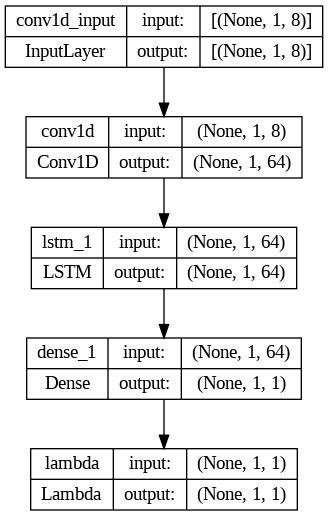

In [29]:
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D, Lambda

model2 = Sequential() 
model2.add(Conv1D(filters= 64, kernel_size=3, padding='same', activation='relu', input_shape=(time_steps, X_train_seq.shape[2])))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dense(1))
model2.add(Lambda(lambda x: x * 400))

print(model2.summary())
plot_model(model2, show_shapes=True)

In [30]:
# Definisikan optimizer Adam dengan learning rate yang diinginkan
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import Huber
optimizer = SGD(learning_rate=0.0001)  
model.compile(optimizer=optimizer, loss='huber',metrics=RootMeanSquaredError())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss',min_delta=0.01, patience = 12, verbose = 1)
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=2)
mcp = tf.keras.callbacks.ModelCheckpoint(filepath = 'lstm_model_weights.h5', monitor = 'val_root_mean_squared_error', 
                      save_best_only = True, verbose = 1)

In [31]:
history = model.fit(
        X_train_seq,
        y_train_seq,
        epochs=20,
        batch_size=32,
        validation_data=(X_valid_seq, y_valid_seq),
        callbacks=[early_stopping, reduce_lr, mcp]
    )

Epoch 1/20
767/771 [============================>.] - ETA: 0s - loss: 0.1133 - root_mean_squared_error: 0.4774
Epoch 1: val_root_mean_squared_error improved from inf to 0.51766, saving model to lstm_model_weights.h5
771/771 [==============================] - 7s 6ms/step - loss: 0.1132 - root_mean_squared_error: 0.4773 - val_loss: 0.1332 - val_root_mean_squared_error: 0.5177 - lr: 1.0000e-04
Epoch 2/20
765/771 [============================>.] - ETA: 0s - loss: 0.1126 - root_mean_squared_error: 0.4758
Epoch 2: val_root_mean_squared_error improved from 0.51766 to 0.51763, saving model to lstm_model_weights.h5
771/771 [==============================] - 4s 5ms/step - loss: 0.1126 - root_mean_squared_error: 0.4759 - val_loss: 0.1331 - val_root_mean_squared_error: 0.5176 - lr: 1.0000e-04
Epoch 3/20
764/771 [============================>.] - ETA: 0s - loss: 0.1124 - root_mean_squared_error: 0.4754
Epoch 3: val_root_mean_squared_error improved from 0.51763 to 0.51761, saving model to lstm_model

In [32]:
y_pred = model.predict(X_test_seq)

mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

20/20 [==============================] - 1s 2ms/step
MAE: 0.4127461069727039
MSE: 0.23713441367665675
RMSE: 0.4869644891330956


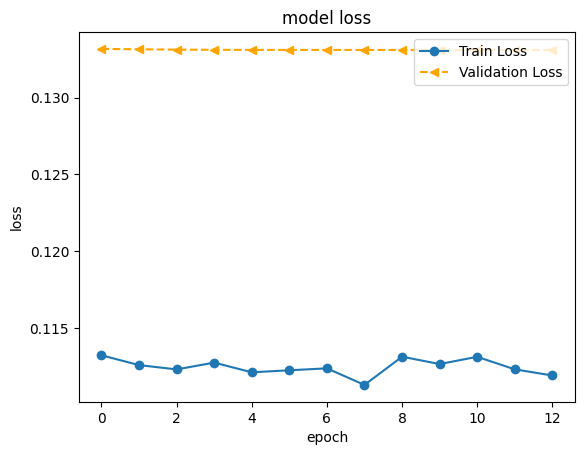

In [33]:
# summarize history for loss
plt.plot(history.history['loss'], '-o', label='Train Loss')
plt.plot(history.history['val_loss'],'--<', color='orange',  label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

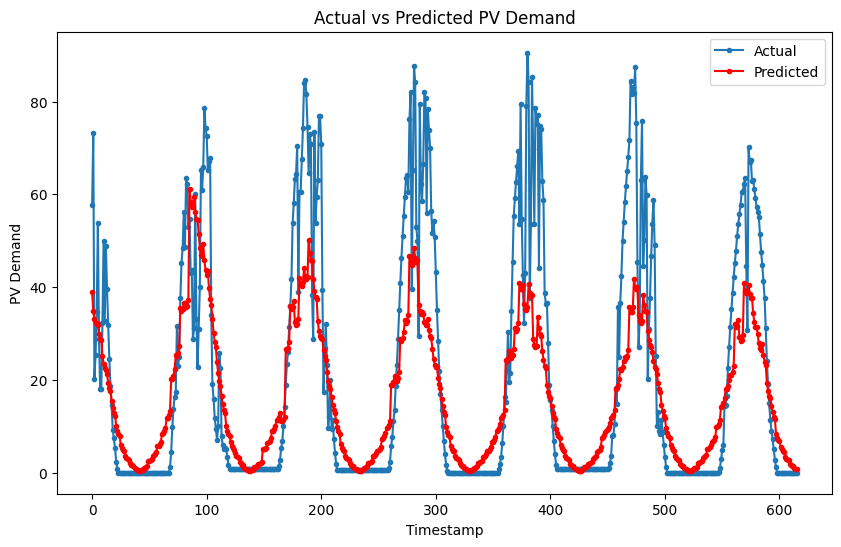

In [34]:
# Membuat array indeks untuk data
index = aa=[x for x in range(len(y_pred))]

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(index, np.power(10, y_test_seq) - 1, label='Actual', marker='.')
plt.plot(index, np.power(10, y_pred+0.5) - 1, label='Predicted', marker='.', color='red')

# Menambahkan label dan judul plot
plt.xlabel('Timestamp')
plt.ylabel('PV Demand')
plt.title('Actual vs Predicted PV Demand')

# Menambahkan legenda
plt.legend()

# Menampilkan plot
plt.show()

# **model 3**

In [35]:
def makeModel(inputSize, seq_length, batchSize, recurrentUnits, outputSize, drop = 0.0, lossf = 'mse'):
    model3 = Sequential()#Keras has 3 methods of implementing models, Sequential, Functional, and subclassing
    #Sequential is used here as it was used in the kaggle sample, but the Functional API is fully-featured (MIMO architectures, complicated models)
    #The architecture used here was chosen to be 'comparable' to the PyTorch architecture, consisting of a reccurent layer, dropout, and a dense (Linear) output.
    model3.add(Input(shape=(seq_length, inputSize), batch_size = batchSize))#The input layers defines the input shape
    model3.add(LSTM(recurrentUnits, return_sequences=True))
    model3.add(Dropout(drop))
    model3.add(Dense(outputSize))
    model3.compile(loss=lossf, optimizer='adam')
    model3.summary()
    return model3

# **model 4**

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense

def makeModel(inputSize, seq_length, batchSize, recurrentUnits, outputSize, drop=0.0, lossf='mse'):
    model4 = Sequential()
    model4.add(Input(shape=(seq_length, inputSize), batch_size=batchSize))
    model4.add(LSTM(recurrentUnits, return_sequences=True))
    model4.add(Dropout(drop))
    model4.add(Dense(outputSize))
    model4.compile(loss=lossf, optimizer='adam')
    model4.summary()
    return model4

# Example values for the model parameters
inputSize = 10
seq_length = 20
batchSize = 32
recurrentUnits = 64
outputSize = 1

# Call the function with the example values to see the summary
makeModel(inputSize, seq_length, batchSize, recurrentUnits, outputSize)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (32, 20, 64)              19200     
                                                                 
 dropout_1 (Dropout)         (32, 20, 64)              0         
                                                                 
 dense_2 (Dense)             (32, 20, 1)               65        
                                                                 
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________


In [37]:
def trainModel(model4,X_test_seq, X_train_seq, y_test_seq, y_pred, numEpochs, batchSize):
    #This is the list of callbacks to call during training
    cbl = [batch_loss_Callback('loss'), EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, restore_best_weights=True)]
    #These give the indices to truncate the train/test sets to avoid an error
    lim1 = (len(X_train_seq)//batchSize)*batchSize
    lim2 = (len(X_test_seq)//batchSize)*batchSize
    #This call trains the model
    history = model4.fit( X_train_seq[:lim1], y_pred[:lim1], epochs=numEpochs, batch_size=batchSize, validation_data=(X_test_seq[:lim2], y_test_seq[:lim2]), verbose=2, shuffle=False, callbacks=cbl)
    return model4, history, cbl[0].losses
